In [2]:
import joblib
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import argparse
import os
from pathlib import Path
import graphviz
from PIL import Image
import re

# python /home/max/stayahead/analysis/scripts/xgb_predict.py -m /home/max/stayahead/analysis/datasets/xgb/outputs/esm/bind_expr/ESM_1step_pred_wuhan_v1_b2b_03-07_model.joblib -x /home/max/stayahead/analysis/datasets/xgb/outputs/esm/bind_expr/X_scaler.joblib -y /home/max/stayahead/analysis/datasets/xgb/outputs/esm/bind_expr/y_scaler.joblib -i /home/max/stayahead/analysis/datasets/current/ESM_BA1_100_b2b_BL.csv -o /home/max/stayahead/analysis/datasets/xgb/outputs/esm_test

def load_scaler(scaler_path):
    return joblib.load(scaler_path)

def preprocess_data(df, feature_columns, x_scaler):
    X = df[feature_columns]
    X_scaled = x_scaler.transform(X)
    return X_scaled

def predict(model, X_scaled, y_scaler):
    # dmatrix = xgb.DMatrix(X_scaled)
    y_pred_scaled = model.predict(X_scaled)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred_scaled)
    return y_pred_rescaled

# def save_predictions(predictions, output_path, target_type):
#     if target_type == 'bind_expr_deltas':
#         predictions_df = pd.DataFrame(predictions, columns=['bind', 'delta_bind', 'expr', 'delta_expr'])
#     elif target_type == 'bind_expr':
#         predictions_df = pd.DataFrame(predictions, columns=['bind', 'expr'])
#     predictions_df.to_csv(output_path, index=False)
#     print(f"Predictions saved to {output_path}")

def calculate_differences(df, predictions, actual_columns, al_type):
    for i, col in enumerate(actual_columns):
        df[f'predicted_{col}'] = predictions[:, i]
        df[f'difference_{col}'] = df[f'predicted_{col}'] - df[col]
    if al_type == 'alphafold':
        df = df.drop(columns=['rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy', 'global_net_energy', 'iptm_ptm', 'iptm', 'pDockQ/mpDockQ', 'average_interface_pae', 'average_interface_plddt', 'binding_energy', 'Num_intf_residues','Polar', 'Hydrophobhic',
 'Charged', 'contact_pairs', 'sc', 'hb', 'sb', 'int_solv_en', 'int_area', 'pi_score', 'agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain'])
    elif al_type == 'esmfold':
        df = df.drop(columns=['rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy', 'global_net_energy', 'agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain'])
    return df

def save_predictions(df, output_path):
    df.to_csv(output_path, index=False)
    print(f"Predictions and differences saved to {output_path}")

In [3]:
model_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train_1/AF/bind_expr/AF_1step_pred_wuhan_v1_b2b_parse_model.json'
x_scaler_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train/AF/bind_expr/X_scaler.joblib'
y_scaler_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train/AF/bind_expr/y_scaler.joblib'
al_type = 'alphafold'
target_type = 'bind_expr'
input_file = '/Users/maxvandenboom/stayahead/analysis/datasets/predictions/variants/af/AF_variants_other_b2b_bloom.csv'
output_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/test/AF_variants_predicted.csv'

In [4]:
model = xgb.XGBRegressor({'n_thread': 4})
model.load_model(model_path)
x_scaler = load_scaler(x_scaler_path)
y_scaler = load_scaler(y_scaler_path)

df = pd.read_csv(input_file)

if al_type == 'esmfold':
    # Make sure to use the same feature columns as in the training script
    feature_columns = ['rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy','agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain']  # ESM
elif al_type == 'alphafold':
    feature_columns = ['rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy', 'iptm_ptm', 'iptm', 'pDockQ/mpDockQ', 'average_interface_pae', 'average_interface_plddt', 'binding_energy', 'Num_intf_residues','Polar', 'Hydrophobhic',
     'Charged', 'contact_pairs', 'sc', 'hb', 'sb', 'int_solv_en', 'int_area', 'pi_score', 'agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain'] # AF
    # feature_columns = ['rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy', 'iptm_ptm', 'pDockQ/mpDockQ', 'average_interface_pae', 'average_interface_plddt', 'binding_energy', 'Polar', 'Hydrophobhic',
    #  'Charged', 'sc', 'int_solv_en', 'int_area', 'pi_score', 'agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain'] # AF
if target_type == 'bind_expr':
    target_columns = ['bind', 'expr']
elif target_type == 'bind_expr_deltas':
    target_columns = ['bind', 'delta_bind', 'expr', 'delta_expr']
X_scaled = preprocess_data(df, feature_columns, x_scaler)

predictions = predict(model, X_scaled, y_scaler)

df_with_predictions = calculate_differences(df, predictions, target_columns, al_type)

# save_predictions(df_with_predictions, output_path)

/Users/maxvandenboom/anaconda3/envs/analysis/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [5]:
print(df_with_predictions)

  seq_id     bind      expr  predicted_bind  difference_bind  predicted_expr  \
0   beta  9.30710  10.00137        7.870780        -1.436320        9.539415   
1  delta  9.03525   9.79026        7.873164        -1.162086        9.742324   
2  o-21k  9.22223   9.73227        6.632103        -2.590127        8.536868   
3  o-21l  9.25549   9.85354        7.106705        -2.148785        8.147352   

   difference_expr  
0        -0.461955  
1        -0.047936  
2        -1.195402  
3        -1.706188  


In [19]:
df = pd.read_csv(input_file)
df_features = df.drop(columns=['seq_id', 'wildtype', 'mutation', 'global_net_energy', 'bind', 'delta_bind', 'expr', 'delta_expr'])
feature_list = df_features.columns.tolist()

bind_expr

In [7]:
df_af = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/current/AF_1step_pred_wuhan_v1_b2b_parse.csv')
df_esm = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/current/ESM_1step_pred_wuhan_v1_b2b_03-07.csv')

In [8]:
df_af.describe()

,site,rmsd,tm_score,sasa,avg_hydro,total_hydro,plddt,local_net_energy,global_net_energy,iptm_ptm,...,helix,ppII,sheet,sidechain,bind,delta_bind,expr,delta_expr,confidence_bind,confidence_expr
count,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,...,3705.000000,3705.000000,3705.000000,3705.000000,3667.000000,3667.000000,3599.000000,3599.000000,3705.000000,3705.000000
mean,98.000000,3.167766,0.987726,10183.579781,-0.241113,-0.225028,93.873832,136764.097713,136764.097713,0.334533,...,0.251243,0.078945,0.373397,0.575292,7.758062,-1.016430,9.247051,-0.938834,-0.124588,-0.124454
std,56.298509,1.170343,0.000663,39.805764,0.021922,0.021663,0.414657,9695.190055,9695.190055,0.100971,...,0.004707,0.001280,0.003351,0.002082,1.164009,1.163159,1.034650,1.034652,0.511565,0.511730
min,1.000000,0.831394,0.981840,10042.305659,-0.287377,-0.269744,90.610067,124509.312592,124509.312592,0.272472,...,0.238631,0.075508,0.365708,0.569446,5.000000,-3.848170,6.358430,-3.826300,-2.509504,-2.227478
25%,49.000000,2.265275,0.987603,10160.004946,-0.256160,-0.239487,93.811624,129701.582650,129701.582650,0.289817,...,0.247892,0.077949,0.370769,0.573836,6.906460,-1.869440,8.430575,-1.754730,0.071936,0.069414
50%,98.000000,3.027272,0.987765,10180.973660,-0.241119,-0.225128,93.954028,131008.536135,131008.536135,0.298095,...,0.251103,0.078949,0.373436,0.575149,8.351140,-0.421670,9.660460,-0.526380,0.072585,0.070030
75%,147.000000,3.959238,0.987869,10203.953305,-0.225472,-0.209231,94.066898,149831.156866,149831.156866,0.315612,...,0.254415,0.079862,0.375667,0.576697,8.620925,-0.152640,10.107605,-0.078270,0.073723,0.071385
max,195.000000,6.756311,0.999680,10425.917937,-0.192139,-0.177436,95.200147,153385.334377,153385.334377,0.829568,...,0.263923,0.082431,0.381744,0.581251,10.596560,1.863240,10.618950,0.433080,0.078435,0.075697


In [9]:
df_esm.describe()

,site,rmsd,tm_score,sasa,avg_hydro,total_hydro,plddt,local_net_energy,global_net_energy,agmata,...,helix,ppII,sheet,sidechain,bind,delta_bind,expr,delta_expr,confidence_bind,confidence_expr
count,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,3705.000000,...,3705.000000,3705.000000,3705.000000,3705.000000,3667.000000,3667.000000,3599.000000,3599.000000,3705.000000,3705.000000
mean,98.000000,13.067328,0.511171,17389.116228,-0.241085,-0.225084,23.431515,138183.297545,138183.297545,0.705843,...,0.251243,0.078945,0.373397,0.575292,7.758062,-1.016430,9.247051,-0.938834,-0.124588,-0.124454
std,56.298509,2.751691,0.087152,860.409872,0.021941,0.021818,0.699396,10260.640794,10260.640794,0.128986,...,0.004707,0.001280,0.003351,0.002082,1.164009,1.163159,1.034650,1.034652,0.511565,0.511730
min,1.000000,2.034227,0.267615,12462.077622,-0.292914,-0.325000,21.787055,113340.518294,113340.518294,0.077744,...,0.238631,0.075508,0.365708,0.569446,5.000000,-3.848170,6.358430,-3.826300,-2.509504,-2.227478
25%,49.000000,11.816996,0.460910,16862.256763,-0.256160,-0.239487,22.980532,129716.658063,129716.658063,0.691841,...,0.247892,0.077949,0.370769,0.573836,6.906460,-1.869440,8.430575,-1.754730,0.071936,0.069414
50%,98.000000,13.068813,0.503596,17354.200913,-0.240967,-0.225128,23.441710,138557.784058,138557.784058,0.701221,...,0.251103,0.078949,0.373436,0.575149,8.351140,-0.421670,9.660460,-0.526380,0.072585,0.070030
75%,147.000000,14.639110,0.549032,17994.606478,-0.225472,-0.209231,23.781169,144656.562236,144656.562236,0.724338,...,0.254415,0.079862,0.375667,0.576697,8.620925,-0.152640,10.107605,-0.078270,0.073723,0.071385
max,195.000000,20.947901,0.961636,20292.638790,-0.192139,-0.177436,41.470246,164568.211490,164568.211490,1.710938,...,0.263923,0.082431,0.381744,0.581251,10.596560,1.863240,10.618950,0.433080,0.078435,0.075697


In [32]:
bind_dif = round(df_with_predictions['difference_bind'].mean(), 3)
expr_dif = round(df_with_predictions['difference_expr'].mean(), 3)
print(f"Average difference in predicted bind: {bind_dif}")
print(f"Average difference in predicted expr: {expr_dif}")


Average difference in predicted bind: -1.272
Average difference in predicted expr: -1.331


bind_expr_deltas

In [38]:
bind_dif = round(df_with_predictions['difference_bind'].mean(), 3)
delta_bind_dif = round(df_with_predictions['difference_delta_bind'].mean(), 3)
expr_dif = round(df_with_predictions['difference_expr'].mean(), 3)
delta_expr_dif = round(df_with_predictions['difference_delta_expr'].mean(), 3)
print(f"Average difference in predicted bind: {bind_dif}")
print(f"Average difference in predicted delta_bind: {delta_bind_dif}")
print(f"Average difference in predicted expr: {expr_dif}")
print(f"Average difference in predicted delta_expr: {delta_expr_dif}")

Average difference in predicted bind: -0.865
Average difference in predicted delta_bind: -0.708
Average difference in predicted expr: -0.642
Average difference in predicted delta_expr: -1.126


In [14]:
feature_columns = ['site', 'rmsd', 'tm_score', 'sasa', 'avg_hydro', 'plddt', 'local_net_energy', 'iptm_ptm', 'iptm', 'pDockQ/mpDockQ', 'average_interface_pae', 'average_interface_plddt', 'binding_energy', 'Num_intf_residues','Polar', 'Hydrophobhic',
 'Charged', 'contact_pairs', 'sc', 'hb', 'sb', 'int_solv_en', 'int_area', 'pi_score', 'agmata', 'backbone', 'coil', 'disoMine', 'earlyFolding', 'helix', 'ppII', 'sheet', 'sidechain']

,seq_id,wildtype,site,mutation,rmsd,tm_score,sasa,avg_hydro,plddt,local_net_energy,...,sc,hb,sb,int_solv_en,int_area,pi_score,bind,delta_bind,expr,delta_expr
0,E133E,E,133,E,7.864741,0.986435,10592.590564,-0.230612,92.279412,140377.471948,...,0.157,13,4,-5.46,1213.23,-1.43,9.22224,0.00000,9.73227,0.00000
1,A188T,A,188,T,7.885648,0.987255,10600.992436,-0.230083,92.248872,124308.187136,...,0.193,17,7,-8.53,1380.59,-0.64,9.17105,-0.05120,9.64973,-0.08255
2,S67N,S,67,N,8.105493,0.986569,10589.807973,-0.231141,92.213144,130351.097416,...,0.108,22,1,-7.84,1470.27,-0.64,8.07826,-1.14399,8.52344,-1.20883
3,C156Y,C,156,Y,8.276780,0.987059,10563.109807,-0.237491,91.681437,142395.280565,...,0.307,12,10,-6.79,1266.06,-0.59,6.46412,-2.75812,8.42514,-1.30713
4,P94H,P,94,H,8.067331,0.980544,10653.118378,-0.233258,92.289116,140728.481366,...,0.180,10,8,4.98,1079.01,-0.66,7.90481,-1.31744,8.27466,-1.45761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,F183W,F,183,W,7.929114,0.979972,10640.030741,-0.235374,91.941995,140558.701012,...,0.193,21,2,-13.08,1644.34,-0.47,8.78742,-0.43482,8.93049,-0.80178
96,N38T,N,38,T,7.884817,0.980666,10608.560480,-0.233787,92.342680,127394.022643,...,0.219,10,0,-6.14,1558.67,-1.67,9.19242,-0.02983,9.53214,-0.20013
97,P189R,P,189,R,7.887028,0.987021,10696.502605,-0.214739,92.137332,144193.738012,...,0.151,14,0,-5.96,1344.20,-1.46,9.13244,-0.08981,9.50460,-0.22767
98,K92S,K,92,S,7.061385,0.987197,10599.802392,-0.244898,92.005036,148247.934374,...,0.145,12,1,-6.71,1277.25,-1.15,8.09711,-1.12513,8.73840,-0.99387


In [25]:
import os
import pandas as pd
import ast

def extract_dict_from_first_line(file_path):
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
        dict_str = first_line.split("Best Parameters: ")[1]
        return ast.literal_eval(dict_str)


def main(directory_path):
    data = []
    file_names = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(directory_path, file_name)
            data.append(extract_dict_from_first_line(file_path))
            file_names.append(os.path.splitext(file_name)[0])  # Get file name without extension
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df.insert(0, 'type', file_names)  # Insert the 'type' column at the first position
    return df

# Example usage
directory_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train/logs'  # replace with your directory path
df = main(directory_path)
print(df)

                         type booster    lambda     alpha  subsample  \
0  ESM_1step_bind_expr_deltas  gbtree  0.449207  0.737385   0.823865   
1          AF_1step_bind_expr    dart  0.963952  0.948372   0.939120   
2         ESM_1step_bind_expr    dart  0.245671  0.533483   0.885387   
3   AF_1step_bind_expr_deltas  gbtree  0.933775  0.587824   0.828924   

   colsample_bytree  max_depth  min_child_weight       eta     gamma  \
0          0.925970         11                 1  0.038321  0.001698   
1          0.959310          7                10  0.082826  0.461388   
2          0.754991         14                 8  0.874268  0.914877   
3          0.967325          8                 6  0.039773  0.634680   

  grow_policy sample_type normalize_type  rate_drop  skip_drop  
0   lossguide         NaN            NaN        NaN        NaN  
1   lossguide    weighted           tree   0.841440   0.561474  
2   lossguide    weighted           tree   0.767464   0.122762  
3   depthwise     

In [96]:
dir_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/predict/train'
out_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/predict/train/rankings'

for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file))
        name = os.path.splitext(file)[0]
        type = name.split('_')[-1]
        if type == 'deltas':
            columns_to_rank = ['bind', 'delta_bind', 'expr', 'delta_expr']
        elif type == 'predict':
            columns_to_rank = ['bind', 'expr']

        # Create a new DataFrame to store the ranks
        ranks = pd.DataFrame(df['seq_id'])

        # Rank the seq_id based on actual and predicted values
        for column in columns_to_rank:
            actual_rank_col = f'rank_{column}'
            predicted_rank_col = f'rank_predicted_{column}'
            rank_diff_col = f'rank_diff_{column}'
            
            # Rank based on actual values
            ranks[actual_rank_col] = df[column].rank(ascending=False)
            
            # Rank based on predicted values
            ranks[predicted_rank_col] = df[f'predicted_{column}'].rank(ascending=False)

            # Calculate the difference in ranks
            ranks[rank_diff_col] =  ranks[predicted_rank_col] - ranks[actual_rank_col]

        # Optionally, you can compare the rankings to see if they match
        for column in columns_to_rank:
            actual_rank_col = f'rank_{column}'
            predicted_rank_col = f'rank_predicted_{column}'
            
            # Check if the rankings are the same
            ranks[f'match_{column}'] = ranks[actual_rank_col] == ranks[predicted_rank_col]

        ranks = ranks.sort_values(by='rank_bind', ascending=True)

        outfile = os.path.join(out_path, f'{name}.csv')

        ranks.to_csv(outfile, index=False)
    else:
        continue



ranks

# 

,seq_id,rank_bind,rank_predicted_bind,rank_diff_bind,rank_delta_bind,rank_predicted_delta_bind,rank_diff_delta_bind,rank_expr,rank_predicted_expr,rank_diff_expr,rank_delta_expr,rank_predicted_delta_expr,rank_diff_delta_expr,match_bind,match_delta_bind,match_expr,match_delta_expr
50,F43E,1.0,66.0,65.0,1.0,79.0,78.0,2.0,84.0,82.0,2.0,79.0,77.0,False,False,False,False
33,A44V,2.0,100.0,98.0,2.0,100.0,98.0,3.0,42.0,39.0,3.0,59.0,56.0,False,False,False,False
70,L186A,3.0,26.0,23.0,3.0,11.0,8.0,4.0,7.0,3.0,4.0,6.0,2.0,False,False,False,False
87,F43R,4.0,7.0,3.0,4.0,5.0,1.0,9.0,20.0,11.0,9.0,29.0,20.0,False,False,False,False
0,L3K,5.0,10.0,5.0,5.0,39.0,34.0,13.0,44.0,31.0,13.0,38.0,25.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Y169C,96.0,1.0,-95.0,96.0,4.0,-92.0,25.0,13.0,-12.0,25.0,10.0,-15.0,False,False,False,False
83,V69E,97.0,94.0,-3.0,97.0,90.0,-7.0,79.0,50.0,-29.0,79.0,44.0,-35.0,False,False,False,False
7,Y163C,98.0,15.0,-83.0,98.0,6.0,-92.0,74.0,21.0,-53.0,74.0,14.0,-60.0,False,False,False,False
56,Y91D,99.0,38.0,-61.0,99.0,33.0,-66.0,87.0,41.0,-46.0,87.0,40.0,-47.0,False,False,False,False


In [97]:
dir1 = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/predict/train'
dir2 = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/predict/train/rankings'
out_dir = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/predict/train/diff'

for file in os.listdir(dir1):
    if file.endswith('.csv'):
        df1 = pd.read_csv(os.path.join(dir1, file))
        df2 = pd.read_csv(os.path.join(dir2, file))

        name = os.path.splitext(file)[0]
        type = name.split('_')[-1]
        if type == 'deltas':
            # Define the selected columns from both datasets
            selected_columns_df1 = ['seq_id', 'difference_bind', 'difference_delta_bind', 'difference_expr', 'difference_delta_expr']
            selected_columns_df2 = ['seq_id', 'rank_diff_bind', 'rank_diff_delta_bind', 'rank_diff_expr', 'rank_diff_delta_expr']
            desired_order = ['seq_id', 'difference_bind', 'rank_diff_bind', 'difference_delta_bind', 'rank_diff_delta_bind', 'difference_expr', 'rank_diff_expr', 'difference_delta_expr', 'rank_diff_delta_expr']
        elif type == 'predict':
            # Define the selected columns from both datasets
            selected_columns_df1 = ['seq_id', 'difference_bind', 'difference_expr']
            selected_columns_df2 = ['seq_id', 'rank_diff_bind', 'rank_diff_expr']
            desired_order = ['seq_id', 'difference_bind', 'rank_diff_bind', 'difference_expr', 'rank_diff_expr']

        # Select the relevant columns from both dataframes
        df1_selected = df1[selected_columns_df1]
        df2_selected = df2[selected_columns_df2]

        # Merge the selected columns from both dataframes on 'seq_id'
        merged_df = pd.merge(df1_selected, df2_selected, on='seq_id')

        # Reorder the columns to match the desired order
        # desired_order = ['seq_id', 'difference_bind', 'rank_diff_bind', 'difference_delta_bind', 'rank_diff_delta_bind', 'difference_expr', 'rank_diff_expr', 'difference_delta_expr', 'rank_diff_delta_expr']
        merged_df = merged_df[desired_order]

        # print(merged_df)
        outfile = os.path.join(out_dir, f'{name}.csv')
        merged_df.to_csv(outfile, index=False)
    else:
        continue

In [95]:
df

,seq_id,wildtype,site,mutation,bind,delta_bind,expr,delta_expr,predicted_bind,difference_bind,predicted_delta_bind,difference_delta_bind,predicted_expr,difference_expr,predicted_delta_expr,difference_delta_expr
0,L3K,L,3,K,9.28202,0.02653,9.87939,0.02585,7.750212,-1.531808,-1.328306,-1.354836,8.731316,-1.148074,-1.720301,-1.746151
1,S182M,S,182,M,8.71450,-0.54099,9.03298,-0.82056,7.449617,-1.264883,-1.417330,-0.876340,8.710088,-0.322892,-1.841308,-1.020748
2,Q142C,Q,142,C,7.88949,-1.36600,8.85378,-0.99977,7.316500,-0.572990,-1.510571,-0.144571,8.760648,-0.093132,-1.578699,-0.578929
3,D32P,D,32,P,8.63048,-0.62501,8.56271,-1.29083,7.618561,-1.011919,-1.449437,-0.824427,9.076130,0.513420,-1.497510,-0.206680
4,F158Q,F,158,Q,9.21602,-0.03947,9.95497,0.10143,7.545498,-1.670522,-1.481450,-1.441980,8.793142,-1.161828,-1.604913,-1.706343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,N128M,N,128,M,9.10832,-0.14717,9.49511,-0.35843,7.470599,-1.637721,-1.483489,-1.336319,8.654800,-0.840310,-1.616906,-1.258476
96,F154P,F,154,P,9.04183,-0.21366,10.05017,0.19663,7.683031,-1.358799,-1.284884,-1.071224,8.733952,-1.316217,-1.122398,-1.319028
97,L120N,L,120,N,8.89665,-0.35884,9.95707,0.10353,7.512292,-1.384358,-1.448048,-1.089208,8.612861,-1.344209,-1.593884,-1.697414
98,Y89R,Y,89,R,8.77475,-0.48074,8.71523,-1.13832,7.729784,-1.044966,-1.240064,-0.759324,8.663735,-0.051495,-1.921380,-0.783060


In [47]:
model_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train_1/ESM/bind_expr/ESM_1step_pred_wuhan_v1_b2b_03-07_model.json'
model = xgb.XGBRegressor({'n_thread': 4})
model.load_model(model_path)

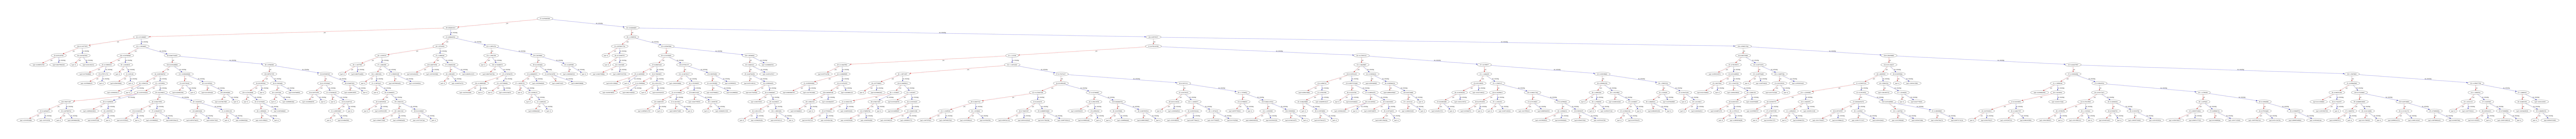

In [41]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=1000)  # You can adjust these values as needed
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()

In [55]:
def box_count(img, save_path, min_box_size=5, max_box_size=None):
    if max_box_size is None:
        max_box_size = min(img.size) // 2

    # Instead of a fixed step, let's use a logarithmic scale for box sizes
    sizes = np.logspace(np.log10(min_box_size), np.log10(max_box_size), num=100, endpoint=True)
    # Rest of the code remains the same


    # sizes = range(min_box_size, max_box_size, step)
    counts = []

    for size in sizes:
        count = 0
        size = int(size)
        for x in range(0, img.width, size):
            for y in range(0, img.height, size):
                box = img.crop((x, y, x + size, y + size))
                if np.any(np.array(box)):
                    count += 1
        counts.append(count)

    sizes = np.array(sizes)
    counts = np.array(counts)
    coeffs = np.polyfit(np.log(1/sizes), np.log(counts), 1)
    fractal_dimension = coeffs[0]

    plt.figure()
    plt.loglog(sizes, counts, 'b.-', markersize=10)
    plt.title(f'Fractal Dimension = {fractal_dimension:.2f}')
    plt.xlabel('1/Size')
    plt.ylabel('Count')
    plt.savefig(save_path, format='png', dpi=300)
    print(f"Plot saved to {save_path}")

    plt.show()

    return fractal_dimension

Plot saved to /Users/maxvandenboom/stayahead/analysis/plots/xgb/fd_test/ESM_bind_expr_deltas_train_1.png


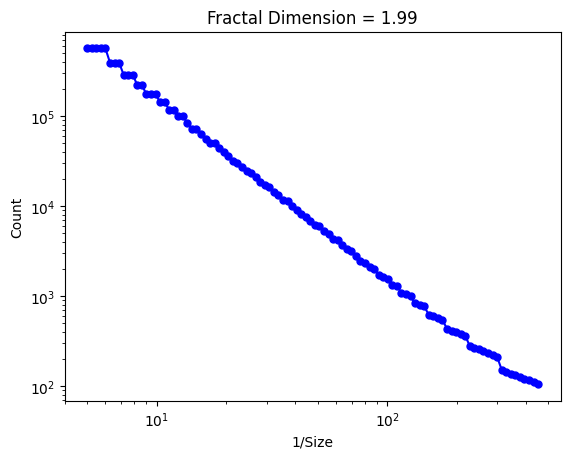

In [56]:
img = Image.open('/Users/maxvandenboom/stayahead/analysis/plots/xgb/ESM_bind_expr_deltas_train_1.png').convert('L')  # Convert to grayscale
bw = img.point(lambda x: 0 if x < 128 else 1, '1')  # Convert to black and white
fractal_dimension = box_count(bw, '/Users/maxvandenboom/stayahead/analysis/plots/xgb/fd_test/ESM_bind_expr_deltas_train_1.png')

In [ ]:
in_dir = '/Users/maxvandenboom/stayahead/analysis/plots/xgb/tree'
save_dir = '/Users/maxvandenboom/stayahead/analysis/plots/xgb/fractal_dims_2'
for file in os.listdir(in_dir):
    image = os.path.join(in_dir, file)
    name = os.path.splitext(file)[0]
    save_name = name + '.png'
    # Load your tree image
    img = Image.open(image).convert('L')  # Convert to grayscale
    bw = img.point(lambda x: 0 if x < 128 else 1, '1')  # Convert to black and white
    save_path = os.path.join(save_dir, save_name)
    # Compute the fractal dimension
    fractal_dimension = box_count(bw, save_path)

In [76]:
model_path = '/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/tmp/train_1/AF/bind_expr_deltas/AF_1step_pred_wuhan_v1_b2b_parse_model.json'
model = xgb.XGBRegressor({'n_thread': 4})
model.load_model(model_path)
booster = model.get_booster()
model_dump = booster.get_dump(with_stats=True)

In [62]:
def extract_impurities(model_dump):
    """Extract impurity (gain) values from the model dump."""
    impurity_list = []
    gain_pattern = re.compile(r'gain=([\d\.]+)')

    for tree in model_dump:
        gains = gain_pattern.findall(tree)
        gains = [float(gain) for gain in gains]
        impurity_list.append(gains)
    
    return impurity_list

def calculate_average_impurity(impurity_list):
    """Calculate the average impurity for each tree and overall average impurity."""
    tree_avg_impurities = [sum(gains) / len(gains) if gains else 0 for gains in impurity_list]
    overall_avg_impurity = sum(tree_avg_impurities) / len(tree_avg_impurities) if tree_avg_impurities else 0
    return tree_avg_impurities, overall_avg_impurity

In [77]:
# Extract and calculate impurities
impurity_list = extract_impurities(model_dump)
tree_avg_impurities, overall_avg_impurity = calculate_average_impurity(impurity_list)

# Display the results
print("Average impurity per tree:", tree_avg_impurities)
print("Overall average impurity:", overall_avg_impurity)

Average impurity per tree: [12.19126031442683, 12.052981149022223, 16.651917239545455, 16.544350279999993, 12.627467243063286, 11.513202287033334, 16.052887567405804, 13.629313081162499, 11.640921611266663, 11.584788206075947, 12.989473649636366, 13.165789306473679, 10.31090776611765, 10.060428198783134, 13.211197096549293, 13.342644977246378, 11.45992174088571, 10.360490086902436, 12.344572938657539, 11.58770213376623, 9.624943365941862, 10.231112506692304, 10.133374214848839, 11.750850548356166, 8.52607955348315, 8.68729748078022, 10.55429515183784, 10.215102096597699, 9.089606289487806, 8.966871528790126, 8.704295044872344, 10.375062200157892, 9.22072854551765, 8.616504296375, 10.36807253672603, 9.796094949013694, 8.47458802351111, 8.103608560299998, 10.107138151205481, 9.70408566953425, 8.743336166971428, 7.836201241166672, 8.59110196288235, 7.720512496311826, 8.031692223542171, 7.562693005629631, 9.159385143919996, 7.398411802224997, 7.518791807472223, 7.1122145330625015, 8.355872

In [46]:
tree_depths = []
num_nodes = []
num_leaves = []
tree_impurities = []

for tree in model_dump:
    depth = 0
    nodes = 0
    leaves = 0
    for line in tree.split('\n'):
        if line.strip():
            nodes += 1
            if 'leaf' in line:
                leaves += 1
                # Extract impurity, assuming leaf value is used as a proxy
                parts = line.split('leaf=')
                if len(parts) > 1:
                    impurity = float(parts[1].split(',')[0])
                    tree_impurities.append(impurity)
            else:
                # Calculate depth by counting the number of tabs, which indicate the level of the node
                level = line.count('\t')
                depth = max(depth, level)
    
    tree_depths.append(depth + 1)  # depth + 1 because depth of tree starts from 0
    num_nodes.append(nodes)
    num_leaves.append(leaves)

# Calculate average metrics across all trees
average_depth = sum(tree_depths) / len(tree_depths)
average_nodes = sum(num_nodes) / len(num_nodes)
average_leaves = sum(num_leaves) / len(num_leaves)
average_impurity = sum(tree_impurities) / len(tree_impurities) if tree_impurities else None

print("Average Tree Depth:", average_depth)
print("Average Number of Nodes:", average_nodes)
print("Average Number of Leaves:", average_leaves)
print("Average Leaf Impurity:", average_impurity)

Average Tree Depth: 13.9975
Average Number of Nodes: 321.52
Average Number of Leaves: 161.26
Average Leaf Impurity: -0.0026480855563574663


In [27]:
import pandas as pd
ba1 = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/current/ESM_1step_pred_wuhan_v1_b2b_03-07.csv')
ba2 = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/tmp/omicron_variants/af/outputs/AF_BA2_100_complete.csv')
ba3 = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/tmp/omicron_variants/esm/ESM_BA1_100_b2b.csv')
ba_pred = pd.read_csv('/Users/maxvandenboom/stayahead/analysis/datasets/xgb/outputs/datasets/full/train/ESM_BA2_100_predict_deltas_w_rank.csv')

In [28]:
ba_pred.describe()

,site,bind,delta_bind,expr,delta_expr,predicted_bind,difference_bind,predicted_delta_bind,difference_delta_bind,predicted_expr,...,rank_diff_bind,rank_delta_bind,rank_predicted_delta_bind,rank_diff_delta_bind,rank_expr,rank_predicted_expr,rank_diff_expr,rank_delta_expr,rank_predicted_delta_expr,rank_diff_delta_expr
count,100.000000,99.000000,99.000000,99.000000,99.000000,100.000000,99.000000,100.000000,99.000000,100.000000,...,99.000000,99.000000,100.000000,99.000000,99.000000,100.000000,99.000000,99.000000,100.000000,99.000000
mean,102.990000,8.193350,-1.062139,9.103622,-0.749922,7.356052,-0.838040,-1.672716,-0.611957,8.319619,...,0.555556,50.000000,50.500000,0.717172,50.000000,50.500000,0.434343,50.000000,50.500000,0.464646
std,54.948736,1.001163,1.001163,0.663241,0.663241,0.271707,1.057647,0.260724,1.072337,0.366097,...,41.726814,28.721037,29.009751,42.921152,28.721037,29.009751,42.661497,28.721037,29.009751,43.264567
min,2.000000,6.106190,-3.149300,7.766220,-2.087330,6.149381,-3.180279,-2.740639,-2.814809,7.811482,...,-95.000000,1.000000,1.000000,-92.000000,1.000000,1.000000,-93.000000,1.000000,1.000000,-92.000000
25%,59.500000,7.263480,-1.992010,8.456555,-1.396990,7.233032,-1.689714,-1.812394,-1.398718,8.084250,...,-25.000000,25.500000,25.750000,-26.000000,25.500000,25.750000,-31.000000,25.500000,25.750000,-28.500000
50%,106.500000,8.606430,-0.649060,9.047260,-0.806290,7.403103,-1.100353,-1.692655,-0.984745,8.205419,...,1.000000,50.000000,50.500000,0.000000,50.000000,50.500000,3.000000,50.000000,50.500000,6.000000
75%,146.250000,9.110470,-0.145020,9.739795,-0.113750,7.525587,0.024538,-1.522532,0.301021,8.549542,...,28.500000,74.500000,75.250000,28.500000,74.500000,75.250000,31.000000,74.500000,75.250000,34.000000
max,194.000000,9.362540,0.107050,10.087660,0.234110,7.883282,1.585852,-0.971350,1.818580,9.551314,...,98.000000,99.000000,100.000000,98.000000,99.000000,100.000000,83.000000,99.000000,100.000000,77.000000
